# CFOSAT-based swells forecast
## Notebook 6. WW3 Superspectra Satellite forecast validation

In [1]:
import sys
import os
import os.path as op
import glob

import numpy as np
import pandas as pd
import datetime
import netCDF4 as netcdf
from math import pi
import xarray as xr

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
from lib import model, sat, plot_sat
from lib.config import * 

In [4]:
# load arrival time and energy from CFOSAT
ds_params = xr.open_dataset(op.join(p_output, 'params_output.nc'))
sat = xr.open_dataset(op.join(p_output, 'params_freqs_output.nc'))

# spectral forecast 
#spec = model.spec_st_ndays('W1765S135')
spec = model.spec_st_ndays('W1760S130')

In [5]:
sat

<xarray.Dataset>
Dimensions:   (file: 118, k: 32, nbox: 498, posneg: 2, theta: 24)
Coordinates:
  * file      (file) object 'CFO_OP05_SWI_L2_____F_20210530T205855_20210530T2...
  * nbox      (nbox) int64 9 10 11 12 13 14 15 ... 500 501 502 503 504 505 506
  * theta     (theta) int64 0 15 30 45 60 75 90 ... 255 270 285 300 315 330 345
  * posneg    (posneg) int64 0 1
  * k         (k) float32 0.01257 0.01389 0.01535 ... 0.2284 0.2524 0.2789
Data variables:
    time      (file, nbox, posneg, theta) datetime64[ns] ...
    distance  (file, nbox, posneg) float64 ...
    efth      (file, nbox, posneg, theta, k) float64 ...
    H         (file, nbox, posneg, theta, k) float64 ...
    T         (file, k) float32 ...
    Ttime     (file, nbox, posneg, k) float64 ...

In [6]:
df_dat = sat[['Ttime', 'time', 'efth']].to_dataframe().dropna()
df_dat['Date'] = [df_dat['time'].values[i] + np.timedelta64(int(df_dat['Ttime'].values[i]), 's') for i in range(len(df_dat))]
ds_dat = df_dat.to_xarray()

## Satellite-Model Spectral Comparison

In [7]:
time = spec.time.values[40]
time1 = spec.time.values[41]
time

numpy.datetime64('2021-06-15T15:00:00.000000000')

In [8]:
ds_sat_efth = xr.merge([ds_params['bearing1'], ds_dat[['efth', 'Date']]])
df_sat_efth = ds_sat_efth.to_dataframe().dropna()

In [9]:
# select date range
df_sat_efth = df_sat_efth.loc[(df_sat_efth.Date >= time) & (df_sat_efth.Date < time1)]
#df_sat_efth['date'] = pd.to_datetime([datetime.timedelta(seconds=i) + day.astype('M8[ms]').astype('O') for i in df_sat_efth.Ttime.values])
df_sat_efth = df_sat_efth.reset_index().drop(columns={'file', 'nbox', 'theta', 'posneg'})
satEfth_group = df_sat_efth.groupby(by=['bearing1', 'k']).mean().reset_index()

In [23]:
df_sat_efth.sort_values('Date')

k    bearing1    efth                Date
452   0.228383    1.803949  0.0000 2021-06-15 15:00:01
176   0.278947  344.319235  0.0000 2021-06-15 15:00:05
760   0.252402  146.601375  0.0000 2021-06-15 15:00:07
272   0.186984  213.175220  0.0000 2021-06-15 15:00:08
1597  0.169190   43.427030  0.0000 2021-06-15 15:00:19
...        ...         ...     ...                 ...
2130  0.084017  153.289228  0.0041 2021-06-15 17:59:42
986   0.153089  355.873674  0.0000 2021-06-15 17:59:48
1430  0.252402   10.353981  0.0000 2021-06-15 17:59:50
2305  0.138521  356.189985  0.0049 2021-06-15 17:59:52
2823  0.062241  219.322639  0.4162 2021-06-15 17:59:59

[3442 rows x 4 columns]

In [11]:
satEfth_group['S'] = satEfth_group['efth']/satEfth_group['k']

In [12]:
def plot_spectrum(ax,x,y,z,ylim):
    x1 = np.append(x,x[0])
    z1 = np.column_stack((z[:,:],z[:,-1]))
    p1 = ax.pcolormesh(x1,y,np.sqrt(z1))  
    #p1.set_cmap('magma')
    ax.set_ylim(0, ylim)
    ax.set_theta_zero_location('N', offset=0)
    ax.set_theta_direction(-1)


In [20]:
model_efth = spec.sel(time=time)[['efth']]

In [13]:
satEfth_group = satEfth_group.sort_values('S')

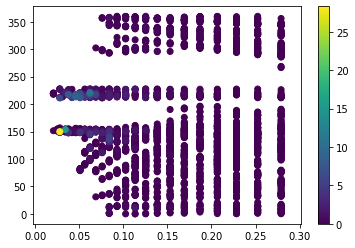

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(satEfth_group.k, satEfth_group.bearing1, c=satEfth_group.S)
plt.colorbar()

In [15]:
dirs = np.sort(spec.direction.values)
freqs = np.sort(spec.frequency.values)

In [16]:
dirs = np.append(dirs, 360)

In [17]:
matrix = np.zeros((len(dirs), len(freqs)))
for pd, d in enumerate(dirs[:-1]):
    for pf, f in enumerate(freqs[:-1]):
        fdir = satEfth_group.loc[(satEfth_group.bearing1 > dirs[pd]) & (satEfth_group.bearing1 < dirs[pd+1])]
        freq = fdir.loc[(satEfth_group.k > freqs[pf]) & (satEfth_group.k < freqs[pf+1])]
        if freq.empty == False:
            matrix[pd, pf] = freq.efth.sum()

In [18]:
sat_efth = xr.Dataset({'efth': (["frequency", "direction"], np.transpose(matrix)),},
    coords={'frequency':freqs,'direction':dirs})

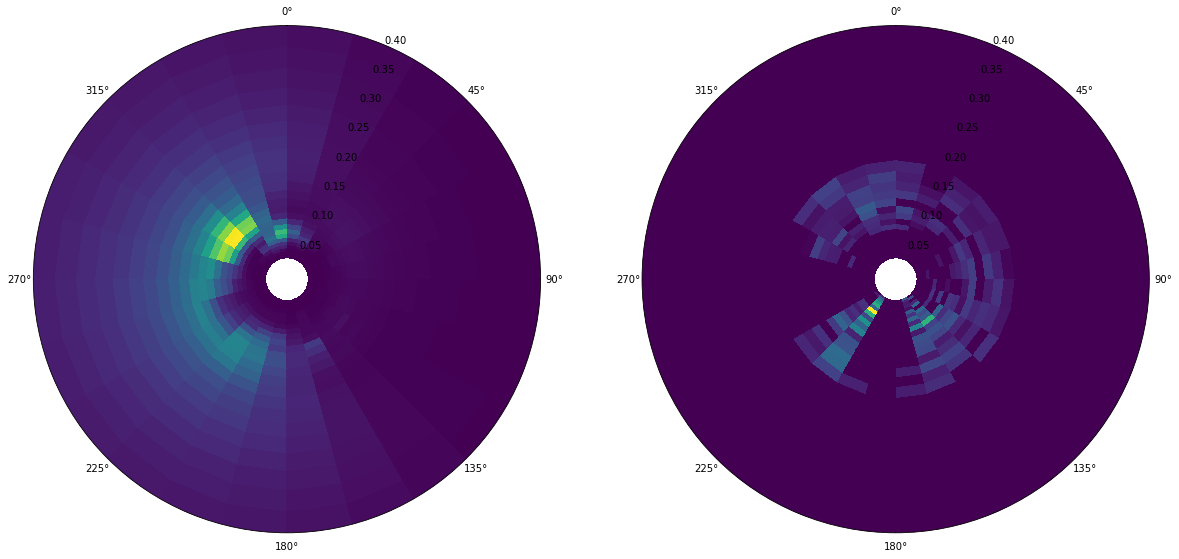

In [21]:
import matplotlib.pyplot as plt
ylim = np.nanmax([np.nanmax(sat_efth.frequency.values), np.nanmax(model_efth.frequency.values)])
ylim = 0.4
fig = plt.figure(figsize=(20,15))

model_efth = model_efth.squeeze()
ax0 = fig.add_subplot(121, projection='polar')
z = np.nanmean(model_efth.efth.values,axis=0)
z = model_efth.efth.values
plot_spectrum(ax0, np.deg2rad(model_efth.direction.values), model_efth.frequency.values, z, ylim)

ax1 = fig.add_subplot(122, projection='polar')
z1 = sat_efth.efth.values
plot_spectrum(ax1, np.deg2rad(sat_efth.direction.values), sat_efth.frequency.values,  z1, ylim)
